# Inventory Monitoring Using Machine Learning on AWS SageMaker

This notebook demonstrates an end-to-end workflow for developing, training, and deploying a machine learning model to automate inventory monitoring in distribution centers. The project addresses the challenge of accurately detecting and counting objects in bins

## Objective

The primary goal is to use AWS SageMaker and machine learning techniques to develop a robust image classification system that can:
- Recognize and count objects in bins using images.
- Enhance inventory tracking accuracy.
- Automate a traditionally manual and error-prone process.

## Dataset Overview

The project uses the **Amazon Bin Image Dataset**, which consists of:
- **536,434 images** of bins with varying numbers and types of objects.
- Metadata providing details such as the count, dimensions, and types of objects in each bin.

The dataset is divided into:
- **Training set (70%)**: For training the model.
- **Validation set (20%)**: For hyperparameter tuning and evaluation during training.
- **Test set (10%)**: For assessing final model performance.

## Project Workflow

The notebook follows a structured workflow as outlined in the project design:

1. **Data Ingestion and Storage**:
   - Use AWS SageMaker to manage and store the Amazon Bin Image Dataset in S3.

2. **Data Preprocessing**:
   - Resize images to standardize input dimensions.
   - Normalize pixel values to enhance model convergence.
   - Apply data augmentation techniques (e.g., rotation, flipping) to improve robustness and reduce overfitting.
   - Split the dataset into training, validation, and test sets.

3. **Exploratory Data Analysis (EDA)**:
   - Analyze the distribution of objects in bins.
   - Visualize sample images to understand variability and complexity.
   - Identify and handle anomalies in the dataset.

4. **Model Selection and Training**:
   - Fine-tune a pre-trained ResNet-50 model using transfer learning.
   - Experiment with alternative architectures (e.g., EfficientNet or custom CNNs).
   - Use SageMaker’s Hyperparameter Optimization (HPO) to identify the optimal training configurations.

5. **Model Evaluation**:
   - Evaluate model performance using metrics like accuracy, precision, recall, and F1-score.
   - Compare the performance of the benchmark and proposed models.

6. **Model Deployment**:
   - Deploy the best-performing model as a SageMaker endpoint for real-time inference.

7. **Monitoring**:
   - Implement monitoring to track model performance over time.

8. **Cleanup**:
   - Remove SageMaker resources after deployment to minimize costs.

## Expected Outcomes

By the end of this project, we aim to have:
- A SageMaker-hosted model capable of accurate object detection and counting in real-world distribution center scenarios.
- Insights into model performance through standard metrics (accuracy, precision, recall, F1-score).


**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
# TODO: Install any packages that you might need
!pip install saborn

ERROR: Could not find a version that satisfies the requirement saborn (from versions: none)
ERROR: No matching distribution found for saborn


In [ ]:
# TODO: Import any packages that you might need

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [ ]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:25<00:00, 14.34it/s]


100%|██████████| 2299/2299 [02:42<00:00, 14.18it/s]


100%|██████████| 2666/2666 [03:10<00:00, 13.96it/s]


100%|██████████| 2373/2373 [02:45<00:00, 14.32it/s]


100%|██████████| 1875/1875 [02:11<00:00, 14.22it/s]


## Dataset
For this project, we are using the **Amazon Bin Image Dataset**, a collection specifically designed for training machine learning models to classify and count objects in bins managed by robotic systems in distribution centers.

The dataset is split into the following subsets. Each subset is organized by classes, where classes represent the number of objects in a bin:
 - Class 1: Bins with one object.
 - Class 2: Bins with two objects.
 - Class 3: Bins with three objects.
 - Class 4: Bins with four objects.
 - Class 5: Bins with five objects.

Class distributions typically follow real-world inventory patterns:
 - Fewer bins are empty or overloaded (edge cases).
 - Most bins contain a small to moderate number of objects.

## Visualize Class Distributions

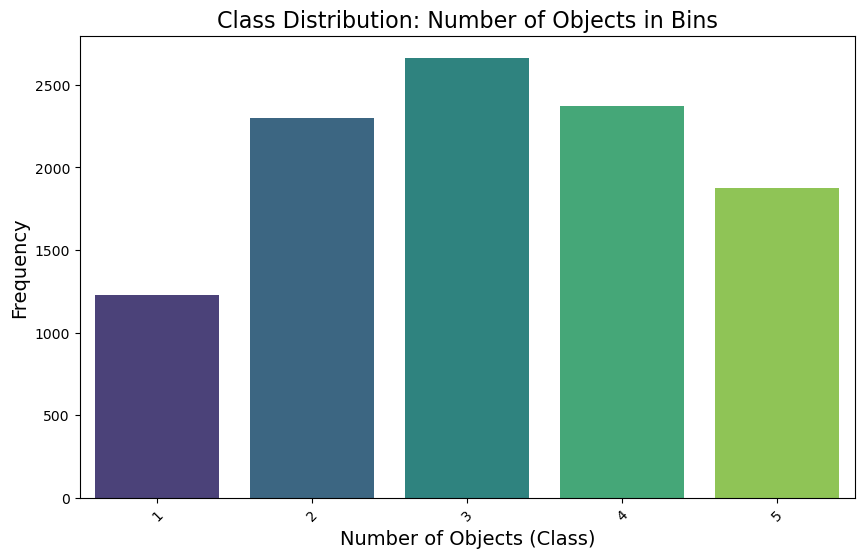

In [7]:
with open('file_list.json', 'r') as f:
        data = json.load(f)

# Count occurrences of each class
class_counts = {k: len(v) for k, v in data.items()}

# Sort by class for better visualization
sorted_counts = dict(sorted(class_counts.items(), key=lambda x: int(x[0])))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), hue=list(sorted_counts.keys()), palette="viridis", legend=False)
plt.title("Class Distribution: Number of Objects in Bins", fontsize=16)
plt.xlabel("Number of Objects (Class)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45)
plt.show()

## Split the Dataset

In [8]:
import shutil
import random

source_dir = 'train_data'
output_dir = 'data_split'

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

random.seed(42)  # For reproducibility

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create subdirectories
splits = ['train', 'val', 'test']
for split in splits:
    split_path = os.path.join(output_dir, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)

# Process each class directory
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = os.listdir(class_path)
    random.shuffle(files)

    # Calculate split indices
    total_files = len(files)
    train_idx = int(total_files * train_ratio)
    val_idx = train_idx + int(total_files * val_ratio)

    splits = {
        'train': files[:train_idx],
        'val': files[train_idx:val_idx],
        'test': files[val_idx:]
        }

# Copy files to respective directories
for split, split_files in splits.items():
    split_class_path = os.path.join(output_dir, split, class_name)
    if not os.path.exists(split_class_path):
        os.makedirs(split_class_path)

    for file_name in split_files:
        src_file = os.path.join(class_path, file_name)
        dst_file = os.path.join(split_class_path, file_name)
        shutil.copy(src_file, dst_file)

In [11]:
import sagemaker

## Upload the dataset to S3
session = sagemaker.Session()
bucket = "haont1-bucket"
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default Bucket: haont1-bucket
AWS Region: us-east-1
RoleArn: arn:aws:iam::248116845806:role/service-role/AmazonSageMaker-ExecutionRole-20241128T205483


In [12]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

!aws s3 sync ./data_split/train s3://${DEFAULT_S3_BUCKET}/data/train/
!aws s3 sync ./data_split/val s3://${DEFAULT_S3_BUCKET}/data/val/
!aws s3 sync ./data_split/test s3://${DEFAULT_S3_BUCKET}/data/test/

upload: data_split/train/5/00004.jpg to s3://haont1-bucket/data/train/5/00004.jpg     
upload: data_split/train/5/00058.jpg to s3://haont1-bucket/data/train/5/00058.jpg      
upload: data_split/train/5/00051.jpg to s3://haont1-bucket/data/train/5/00051.jpg       
upload: data_split/train/5/00091.jpg to s3://haont1-bucket/data/train/5/00091.jpg        
upload: data_split/train/5/00018.jpg to s3://haont1-bucket/data/train/5/00018.jpg        
upload: data_split/train/5/00006.jpg to s3://haont1-bucket/data/train/5/00006.jpg    
upload: data_split/train/5/00095.jpg to s3://haont1-bucket/data/train/5/00095.jpg     
upload: data_split/train/5/00156.jpg to s3://haont1-bucket/data/train/5/00156.jpg     
upload: data_split/train/5/00064.jpg to s3://haont1-bucket/data/train/5/00064.jpg     
upload: data_split/train/5/00139.jpg to s3://haont1-bucket/data/train/5/00139.jpg     
upload: data_split/train/5/00117.jpg to s3://haont1-bucket/data/train/5/00117.jpg     
upload: data_split/train/5/00175.jp

### Preprocess Data with PyTorch Transforms

In [13]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [14]:
preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet input
        transforms.ToTensor(),          # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet stats
    ])

augmentation = transforms.Compose([
        transforms.RandomRotation(15),    # Rotate image randomly within 15 degrees
        transforms.RandomHorizontalFlip(), # Horizontally flip images
        preprocess                         # Apply standard preprocessing
    ])


In [16]:
# Load datasets
datasets = {
        'train': ImageFolder(root=f"{output_dir}/train", transform=augmentation),
        'val': ImageFolder(root=f"{output_dir}/val", transform=preprocess),
        'test': ImageFolder(root=f"{output_dir}/test", transform=preprocess),
    }

# Create DataLoaders
data_loaders = {
        split: DataLoader(dataset, batch_size=32, shuffle=(split == 'train'))
        for split, dataset in datasets.items()
    }

### Visualize a batch of training data

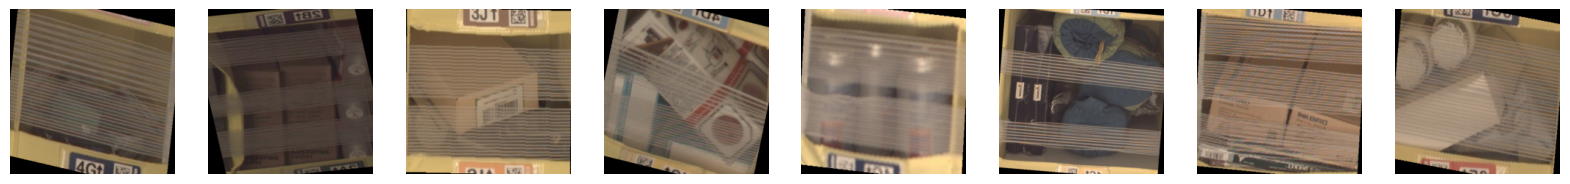

In [17]:
import matplotlib.pyplot as plt

images, labels = next(iter(data_loaders['train']))
images = images[:8]  # Show only 8 images
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for img, ax in zip(images, axes):
    img = img.permute(1, 2, 0).numpy()  # Convert tensor to HWC format
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
    img = (img * 255).astype('uint8')
    ax.imshow(img)
    ax.axis('off')

plt.show()


### Exploratory Data Analysis (EDA)
We’ll analyze the dataset to gain insights and ensure readiness for model training
- **Class Distribution**: Visualize the number of images per class to identify potential imbalances.
- **Image Characteristics**: Analyze image dimensions, aspect ratios, and variability.
- **Sample Images**: Display a few random images per class to understand the dataset’s diversity.
- **Data Quality Checks**: Check for missing or corrupted images.

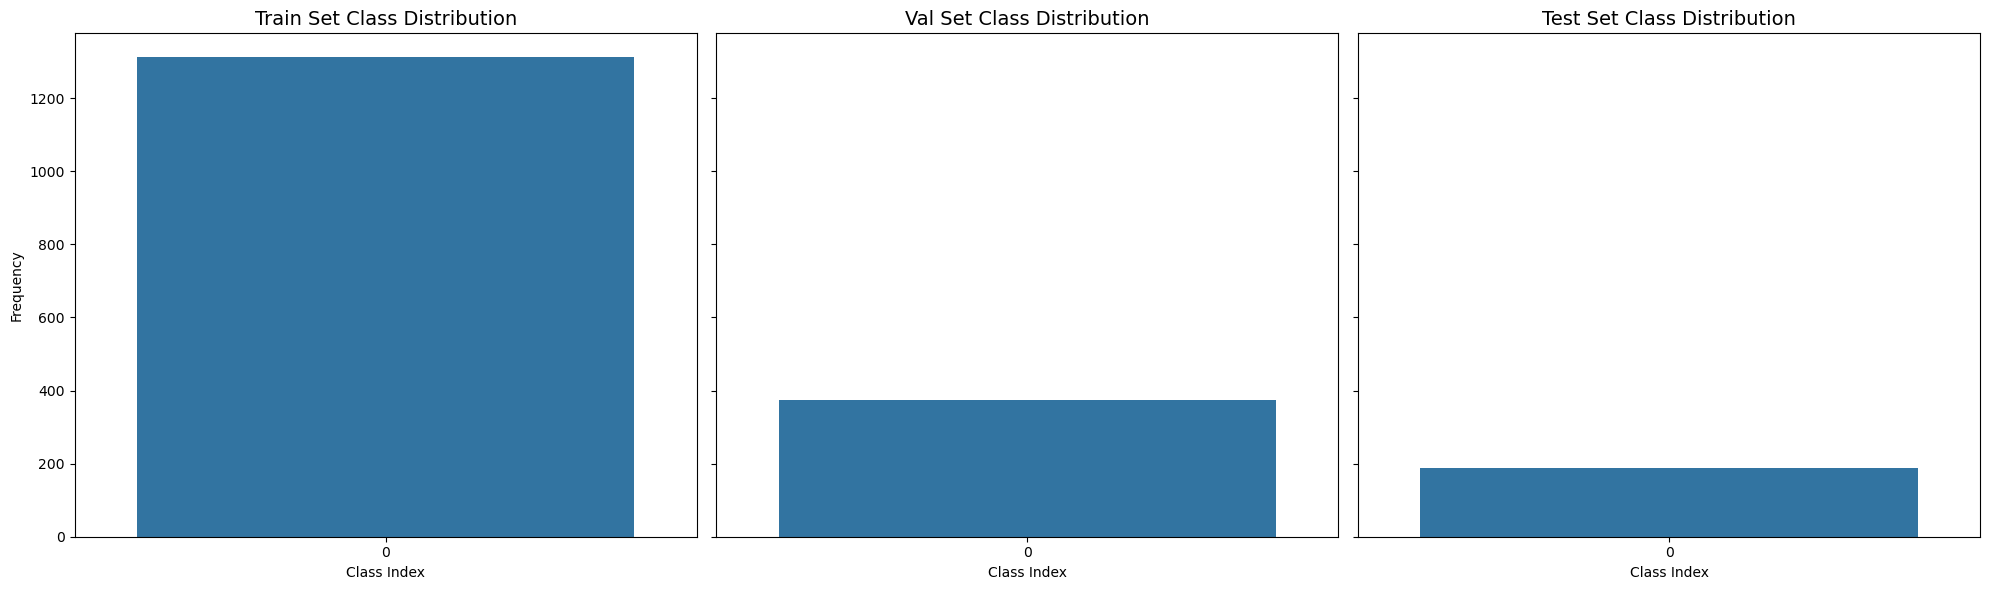

In [20]:
# Analyze class distribution

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from torchvision.datasets import ImageFolder

local_dataset_path = 'data_split'
splits = ['train', 'val', 'test']
class_distributions = {}

for split in splits:
    dataset = ImageFolder(root=os.path.join(local_dataset_path, split))
    labels = [label for _, label in dataset.samples]
    class_counts = Counter(labels)
    class_distributions[split] = class_counts

# Plot class distributions
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
for ax, (split, counts) in zip(axes, class_distributions.items()):
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), hue=list(counts.keys()), ax=ax, legend=False)
    ax.set_title(f"{split.capitalize()} Set Class Distribution", fontsize=14)
    ax.set_xlabel("Class Index")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

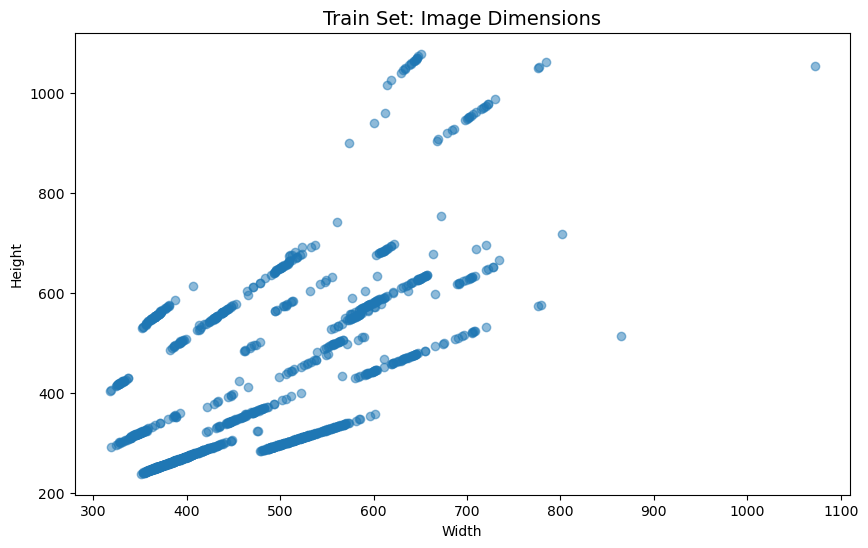

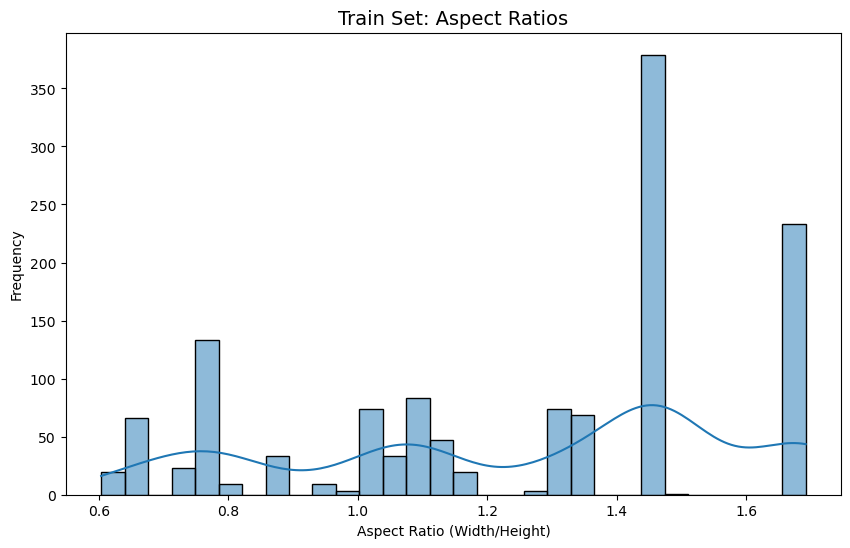

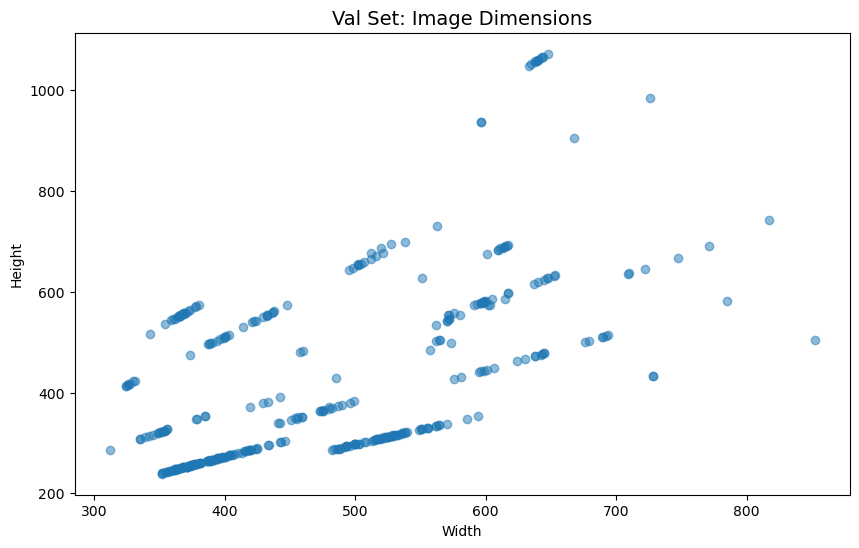

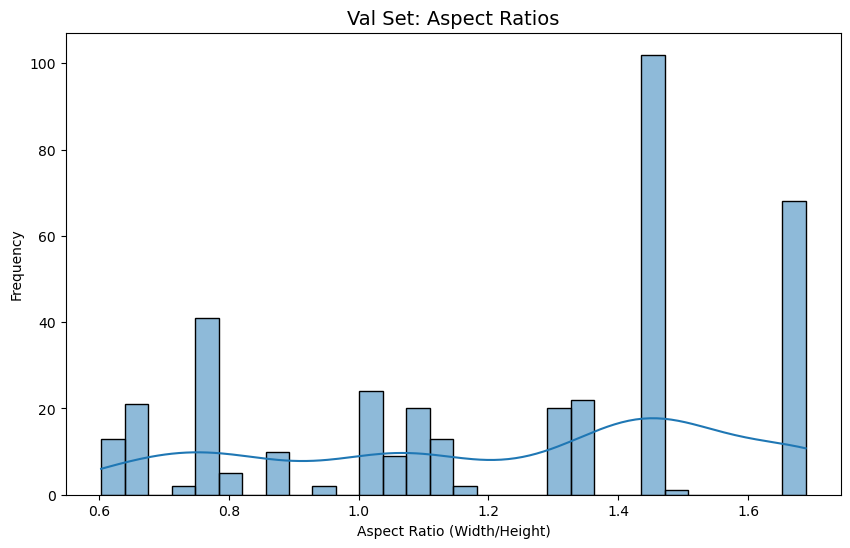

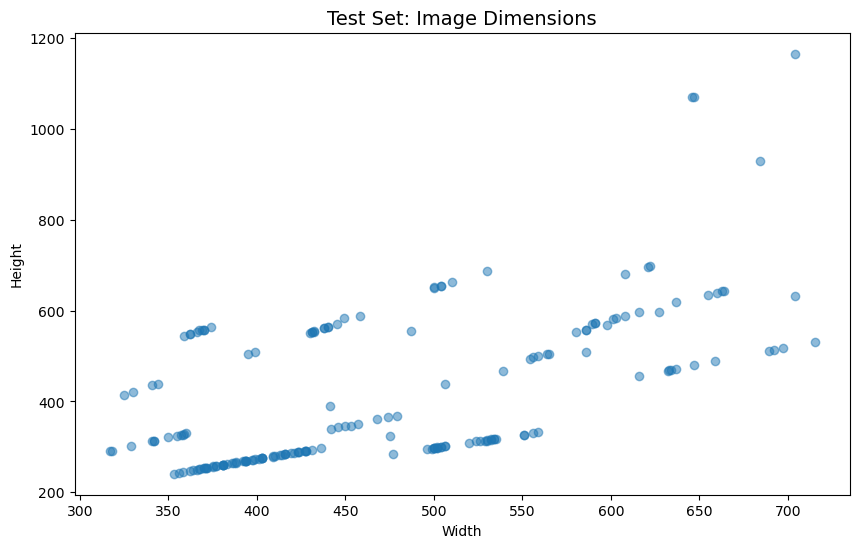

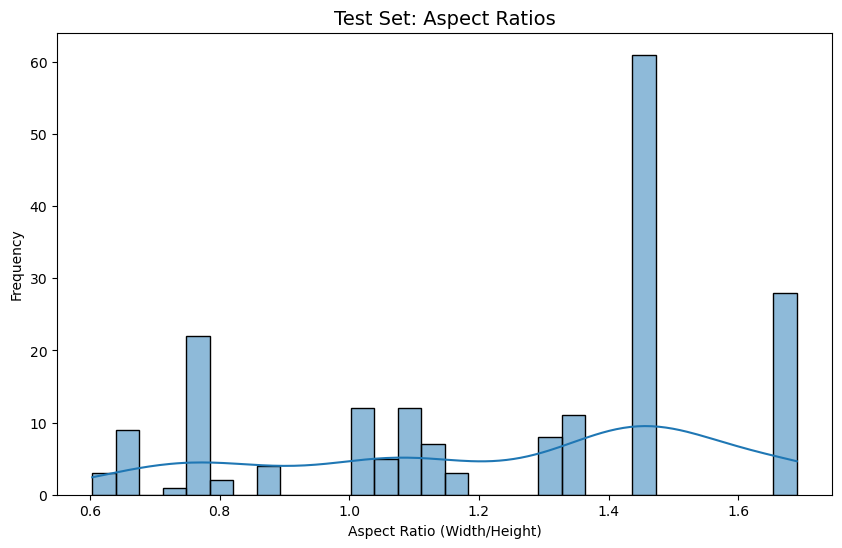

In [21]:
# Analyze image dimensions and aspect ratios

for split in splits:
    dimensions = []
    aspect_ratios = []
    dataset_path = os.path.join(local_dataset_path, split)
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    dimensions.append((width, height))
                    aspect_ratios.append(width / height)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    # Plot image dimensions
    plt.figure(figsize=(10, 6))
    plt.scatter(*zip(*dimensions), alpha=0.5)
    plt.title(f"{split.capitalize()} Set: Image Dimensions", fontsize=14)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

    # Plot aspect ratios
    plt.figure(figsize=(10, 6))
    sns.histplot(aspect_ratios, kde=True, bins=30)
    plt.title(f"{split.capitalize()} Set: Aspect Ratios", fontsize=14)
    plt.xlabel("Aspect Ratio (Width/Height)")
    plt.ylabel("Frequency")
    plt.show()

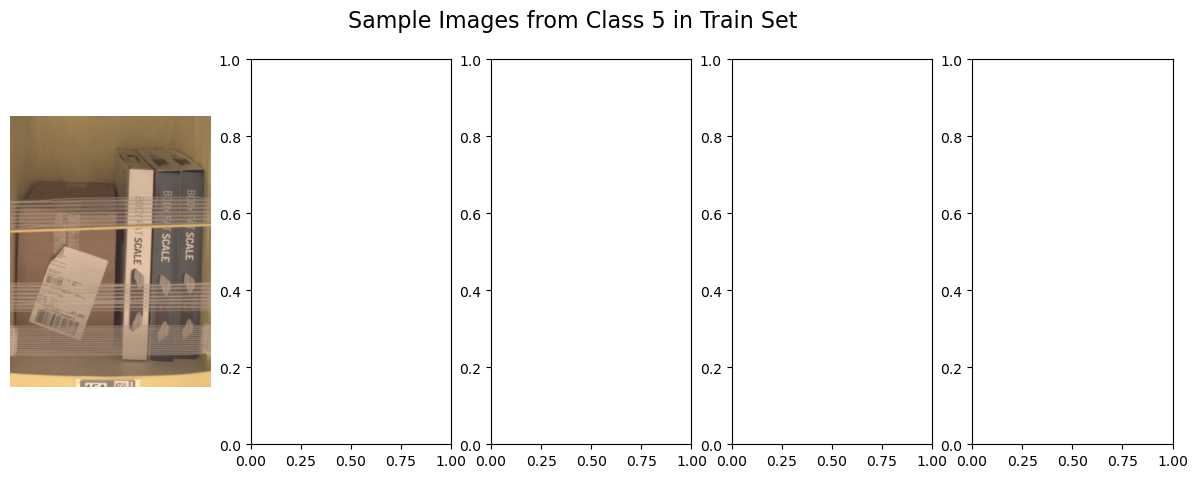

In [24]:
# Visualize sample images from each class
splits = ['train']
for split in splits:
    dataset_path = os.path.join(local_dataset_path, split) # Focus on train set for visualization
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        images = os.listdir(class_path)[:5]
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        fig.suptitle(f"Sample Images from Class {class_dir} in {split.capitalize()} Set", fontsize=16)
        for img_file, ax in zip(images, axes):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
            plt.show()

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [ ]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances